# Extracting Text from Scanned PDF using Pytesseract & Open CV

### We are going to extract table data from pdfs whose data is organized in one of three patterns. 

### After extracting the data from each pdf, we'll transform it and join it with data from other pdfs.

<strike>First Plan:
1. Convert PDFs to images
2. Manually collect Regions Of Interest (ROIs) for each protocol 
3. Use image ROI's to crop images
4. Take cropped image and convert to table data or text
5. ?

Second Plan (1.0):
1. Convert PDFs to images~
2. Manually get coordinates for slicing with GIMP
3. Get cropped images for all pdfs for each type of protocol
</strike>

Third Plan (1.0):
1. Convert PDFs to images
2. Figure out how to get appropriately cropped images for each 
3. Crop all images
4. Convert to text or table data
5. Convert table data to Dataframe
6. Union Urin data 
7. Delete "typical ranges" column, pivot data, and wrangle
8. Join dataframes on datetime
9. Create columns for calculated fields
10. Visualize in Tableau
11. Clean, wrangle, and join other data sources

In [1]:
# # Install necessary packages

# !pip install pdf2image opencv-python Pillow pytesseract

# # use this command to install poppler (on mac you can also use 'brew install poppler')
# !conda install -c conda-forge poppler

# Clean up and sort the pdfs

The strategy is to clean the pdf file names in a specified directory by replacing spaces with underscores and sorting them into lists by protocol. There is a functionto store the full path to each file to make them easier to access, and a function to get just the filename to make them easier to breakdown in dataframes.

In [31]:
# TODO: Figure out how to clean up the file names
# TODO: check for pdf directory in directory, if it doesn't exist, make one
# TODO: Move pdfs to pdf directory as jpgs are created
import os
from re import search

def cleansort_file_paths(directory_path):
    
    """
    Input a directory path string and output three lists, one for each protocol, 
    containing the full path of each file which has been separated by protocol and cleaned.
  
    Parameters:
    directory_path (string): Path to directory containing protocol pdfs
  
    Returns:
    cbc (list) : list containing UCSD-..._Osmo file paths
    osmolality (list) : list containing UCSD-..._Urin file paths
    urinalysis (list) : list containing UCSD-..._CBC file paths
    """
    
    
    cbc = []
    osmolality = []
    urinalysis = []
    
    for filename in os.listdir(directory_path):
        if search("UCSD-..._Osmo", filename):
            new_name = filename.replace(" ","_")
            if filename != new_name:
                os.rename(filename,new_name)
            if new_name not in osmolality:
                osmolality.append(str(directory_path +'/'+new_name))
                
        elif search("UCSD-..._Urin", filename):
            new_name = filename.replace(" ","_")
            if filename != new_name:
                os.rename(filename,new_name)
            if new_name not in urinalysis:
                urinalysis.append(str(directory_path +'/'+new_name))
                    
        elif search("UCSD-..._CBC", filename):
            new_name = filename.replace(" ","_")
            if filename != new_name:
                os.rename(filename,new_name)
            if new_name not in cbc:
                cbc.append(str(directory_path +'/'+new_name))
       
    return cbc, osmolality, urinalysis


In [32]:
import os
from re import search

def cleansort_file_names(directory_path):
    
    """
    Input a directory path string and output three lists, one for each protocol, 
    containing the full path of each file which has been separated by protocol and cleaned.
  
    Parameters:
    directory_path (string): Path to directory containing protocol pdfs
  
    Returns:
    cbc (list) : list containing UCSD-..._Osmo file names
    osmolality (list) : list containing UCSD-..._Urin file names
    urinalysis (list) : list containing UCSD-..._CBC file names
    all_names (list) : list containing all file names
    """
        
    
    cbc = []
    osmolality = []
    urinalysis = []
    all_names = []
    
    for filename in os.listdir(directory_path):
        print(filename)
        if search("UCSD-..._Osmo", filename):
            new_name = filename.replace(" ","_")
            if filename != new_name:
                filename = f'{directory_path}{filename}'
                os.rename(filename,new_name)
            if new_name not in osmolality:
                osmolality.append(str(new_name))
            if new_name not in all_names:
                all_names.append(str(new_name))
                
        elif search("UCSD-..._Urin", filename):
            new_name = filename.replace(" ","_")
            if filename != new_name:
                filename = f'{directory_path}{filename}'
                os.rename(filename,new_name)
            if new_name not in urinalysis:
                 urinalysis.append(str(new_name))
            if new_name not in all_names:
                all_names.append(str(new_name))
                    
        elif search("UCSD-..._CBC", filename):
            new_name = filename.replace(" ","_")
            if filename != new_name:
                os.rename(filename,new_name)
            if new_name not in cbc:
                cbc.append(str(new_name))
            if new_name not in all_names:
                all_names.append(str(new_name))

    return cbc, osmolality, urinalysis, all_names


In [33]:
# The intention is that you could point the directory_path variable at any local directory containing the pdf 
# files and the rest of the notebook would be robust enough to run on any OSX system

directory_path = '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy/'
filepath = directory_path

In [34]:
cbc_paths, osmolality_paths, urinalysis_paths = cleansort_file_paths(directory_path)

In [35]:
cbc_names, osmolality_names, urinalysis_names, all_names = cleansort_file_names(directory_path)

UCSD-001_Osmolality_26APR2022_at_1139_Redacted.pdf1.jpg
.DS_Store
UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf2.jpg
UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf1.jpg
UCSD-001_Urinalysis_26APR2022_at_0958_Redacted.pdf1.jpg
UCSD-001_Urinalysis_26APR2022_at_0958_Redacted.pdf2.jpg
UCSD-001_Urinalysis_26APR2022_at_1212_Redacted.pdf1.jpg
UCSD-001_Urinalysis_26APR2022_at_1212_Redacted.pdf2.jpg
UCSD-001_Osmolality_26APR2022_at_0950_Redacted.pdf1.jpg
UCSD-001_CBC_26APR2022_at_1032_Redacted.pdf1.jpg
UCSD-001_Osmolality_26APR2022_at_1102_Redacted.pdf1.jpg
UCSD-001_Osmolality_26APR2022_at_1207_Redacted.pdf1.jpg
UCSD-001_Osmolality_26APR2022_at_1107_Redacted.pdf1.jpg
UCSD-001_CBC_26APR2022_at_1032_Redacted.pdf2.jpg
UCSD-001_CBC_26APR2022_at_1107_Redacted.pdf1.jpg
UCSD-001_CBC_26APR2022_at_0950_Redacted.pdf2.jpg
UCSD-001_CBC_26APR2022_at_1102_Redacted.pdf2.jpg
UCSD-001_CBC_26APR2022_at_1207_Redacted.pdf2.jpg
UCSD-001_CBC_26APR2022_at_0950_Redacted.pdf1.jpg
UCSD-001_CBC_26APR2022_at_1107_Redacted.pdf2.

## Sample From Each List

In [7]:
cbc_paths[:3]

['/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf2.jpg',
 '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf1.jpg',
 '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1032_Redacted.pdf1.jpg']

In [8]:
osmolality_paths[:3]

['/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_Osmolality_26APR2022_at_1139_Redacted.pdf1.jpg',
 '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_Osmolality_26APR2022_at_0950_Redacted.pdf1.jpg',
 '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_Osmolality_26APR2022_at_1102_Redacted.pdf1.jpg']

In [9]:
urinalysis_paths[:3]

['/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_Urinalysis_26APR2022_at_0958_Redacted.pdf1.jpg',
 '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_Urinalysis_26APR2022_at_0958_Redacted.pdf2.jpg',
 '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_Urinalysis_26APR2022_at_1212_Redacted.pdf1.jpg']

In [10]:
cbc_names[:3]

['UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf2.jpg',
 'UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf1.jpg',
 'UCSD-001_CBC_26APR2022_at_1032_Redacted.pdf1.jpg']

In [11]:
osmolality_names[:3]

['UCSD-001_Osmolality_26APR2022_at_1139_Redacted.pdf1.jpg',
 'UCSD-001_Osmolality_26APR2022_at_0950_Redacted.pdf1.jpg',
 'UCSD-001_Osmolality_26APR2022_at_1102_Redacted.pdf1.jpg']

In [12]:
urinalysis_names[:3]

['UCSD-001_Urinalysis_26APR2022_at_0958_Redacted.pdf1.jpg',
 'UCSD-001_Urinalysis_26APR2022_at_0958_Redacted.pdf2.jpg',
 'UCSD-001_Urinalysis_26APR2022_at_1212_Redacted.pdf1.jpg']

# Extract Data From File Names Into DataFrame
Take each filename from each protocol list and extract the different parts

In [13]:
import pandas as pd

cols = ['filename','partner','patient','protocol','date','time']
data = (None,None,None,None,None,None)

protocol_data = pd.DataFrame(columns = cols)

protocol_data

,filename,partner,patient,protocol,date,time


In [14]:
type(protocol_data)

pandas.core.frame.DataFrame

In [15]:

def split_and_append_data_to_dataframe(list_of_file_names, df_to_append):
    
    """
    Input a list of filenames, and the string will be split into filename, partner, patient,
    protocol, date, time; those splits will be appended to the dataframe given as an input. 
    If those are not the column names in the DataFrame, this function will break.
    
    If the naming convention of the files changes, this function will break.
  
    Parameters:
    list_of_file_names () 
    df_to_append ()
    directory_path (string): Path to directory containing protocol pdfs
  
    Returns:
    None
    """
    
    for i in list_of_file_names:
        if i not in df_to_append['filename']:
            split_list = i.split('_')
            filename = i
            hospital_patient_list = split_list[0].split('-')
            partner = hospital_patient_list[0]
            patient = hospital_patient_list[1]
            protocol = split_list[1]
            date = split_list[2]
            time = split_list[4]
            row = {'filename':filename, 'partner':partner, 'patient':patient, 'protocol':protocol,
                   'date':date, 'time':time}
            df_to_append = df_to_append.append(row, ignore_index=True)
    return df_to_append

In [16]:
protocol_data = split_and_append_data_to_dataframe(all_names, protocol_data)

In [17]:
protocol_data

,filename,partner,patient,protocol,date,time
0,UCSD-001_Osmolality_26APR2022_at_1139_Redacted...,UCSD,001,Osmolality,26APR2022,1139
1,UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf2.jpg,UCSD,001,CBC,26APR2022,1139
2,UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf1.jpg,UCSD,001,CBC,26APR2022,1139
3,UCSD-001_Urinalysis_26APR2022_at_0958_Redacted...,UCSD,001,Urinalysis,26APR2022,0958
4,UCSD-001_Urinalysis_26APR2022_at_0958_Redacted...,UCSD,001,Urinalysis,26APR2022,0958
5,UCSD-001_Urinalysis_26APR2022_at_1212_Redacted...,UCSD,001,Urinalysis,26APR2022,1212
6,UCSD-001_Urinalysis_26APR2022_at_1212_Redacted...,UCSD,001,Urinalysis,26APR2022,1212
7,UCSD-001_Osmolality_26APR2022_at_0950_Redacted...,UCSD,001,Osmolality,26APR2022,0950
8,UCSD-001_CBC_26APR2022_at_1032_Redacted.pdf1.jpg,UCSD,001,CBC,26APR2022,1032
9,UCSD-001_Osmolality_26APR2022_at_1102_Redacted...,UCSD,001,Osmolality,26APR2022,1102


# Convert the PDFs to JPGs

In [36]:
# convert pdf to a jpg

import os, shutil
from pdf2image import convert_from_path

def convert_pdf_to_jpg(directory, file):
    """
    Loop over a directory, using the path and iterator as inputs.
    
    If the file is a pdf, convert it to jpg.
    
    It's unclear how this will react when there are other filetypes besides .pdf in the directory.
  
    Parameters:
    directory (string) - directory path
    file (string) - file name
  
    Returns:
    None
    """
    
    pdf = f"{directory}{file}"
    pages_in_pdf = convert_from_path(pdf, 350) #might need to tweak number depending on size of the image
    i = 1
    for page in pages_in_pdf:
        image_name = f"{pdf}" + str(i) + ".jpg" 
        page.save(image_name, "JPEG")
        i = i+1    

In [37]:
def move_pdfs(directory, file):
    """
    Loop over a directory, using the path and iterator as inputs.
    
    Check if there is a pdf folder, and if not, create it.
    
    Move all pdf files to pdf directory so there are only .jpegs.
      
    Parameters:
    directory (string) - directory path
    file (string) - file name
  
    Returns:
    None
    """
    
    new_dir = f'{directory}pdfs/'
    
    # check if directory exists or not yet
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    if os.path.exists(new_dir):
        file_path = new_dir + file
        print(f'file_path: {file_path}')
        
        # move files into created directory
        shutil.move(directory+file, file_path)


In [38]:
# convert pdf files to jpg
for f in os.listdir(filepath):
#     print(f)
    if f[-4:] == '.pdf':
        convert_pdf_to_jpg(filepath, f)


In [39]:
# create pdf folder if it doesn't already exist, and move pdfs to pdf folder

for f in os.listdir(filepath):
    if f[-4:] == '.pdf':
        move_pdfs(filepath, f)

# Now that we have our images ready to work with, it is time to sort them by protocol and other differentiators and crop them.

### Grab the pixel placement for key segments using GIMP

I used gimp to manually find the position of important segments

### Before cropping, clean up the file names and sort the protocols into lists

In [22]:
import os
from re import search

# Lists of files for each protocol type

# Where to look for the files
# directory_path = '/Users/thomasmulhern/Desktop/COPY_OG_UCSD-001_Hydration_Visit 2_26APR2022 2'

# What the function will search for in the file name
osmo_search = "UCSD-..._Osmo"
urin_search = "UCSD-..._Urin"
cbc_search = "UCSD-..._CBC"

cbc = []
osmolality = []
urinalysis = []
def sort_file(directory_path, search_string, protocol_list):
    """Replace spaces with underscores and rename files before adding them to lists sorted by protocol """
   

    for f in os.listdir(directory_path):
        if search(search_string, f):
#             r = f.replace(" ","_")
#             # r =
#             r = directory_path+'/'+ r
#             f = directory_path+'/'+f
#             os.rename(f,r)
            if f not in protocol_list:
                protocol_list.append(str(directory_path +'/'+f))
            else:
                print(f)
    return cbc, osmolality, urinalysis

sort_file(directory_path, osmo_search, osmolality)
sort_file(directory_path, urin_search, urinalysis)
sort_file(directory_path, cbc_search, cbc)

# print(os.listdir(directory_path))

    

(['/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf2.jpg',
  '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf1.jpg',
  '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1032_Redacted.pdf1.jpg',
  '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1032_Redacted.pdf2.jpg',
  '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1107_Redacted.pdf1.jpg',
  '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_0950_Redacted.pdf2.jpg',
  '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1102_Redacted.pdf2.jpg',
  '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1207_Redacted.pdf2.jpg',
  '/User

In [40]:
# Checking one of the lists to confirm it has full file paths

cbc[0:3]

['/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf2.jpg',
 '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1139_Redacted.pdf1.jpg',
 '/Users/thomasmulhern/dt/OG_UCSD-001_Hydration_Visit 2_26APR2022_copy//UCSD-001_CBC_26APR2022_at_1032_Redacted.pdf1.jpg']

# END OF ROBUST, TESTED CODE

# Now we take the images and crop them


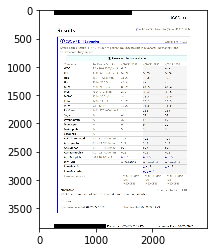

In [24]:
%matplotlib inline

from matplotlib import pyplot as plt

# https://pyimagesearch.com/2021/01/19/crop-image-with-opencv/

# Crop images
# works when I use the Python parser but not when I use Jupyter notebooks

# TODO: Find coordinates for other protocols
# TODO: Test the coordinates on all the different files to make sure they still work
# TODO: Save images after cropping
# TODO: Create funtion to loop through all files in directory
# TODO: create crop function

import argparse
import cv2

# load the input image and display it to our screen

# for i in cbc:
#     if i[-4:] == '.jpg':
#         print(i)

image = cv2.imread(cbc[2])
plt.imshow(image)
plt.show()
# cv2.waitKey(0)
# cv2.destroyAllWindows() #close the image window



# Key coordinates found using GIMP manually

cbc_participant = image[94:180, 2284:2626]
cbc_protocol = image[524:582, 462:586]
cbc_table = image[926:3080, 422:2572]

osmo_participant = image[94:180,2284:2626]
osmo_protocol = image[514:592,360:678]
osmo_table = image[890:1268,410:2604]

urin_participant = image[94:180,2288:2626]
urin_protocol = image[362:666,510:592]
urin_table1 = image[422:2610,906:2132]
urin_table2 = image[422:2610,2466:3168]

# cv2.imshow("Face", cbc_table)
# cv2.waitKey(0)


# def loop_dir(path):
#     pass

# def parse_file(filename):
#     pass

# def crop():
#     pass


# It turns out, manual selection doesn't work

- For Urinalysis, some have a "newer results available banner" while others do not.
- For CBC, some some have a "newer results available banner" while others do not, and some have table rows for Imm Gran % and Imm Gran Abs while others do not
- For Osmolality, some have a "newer results available banner" while others do not.

In [25]:
#  # This is the code I used to manually find ROIs of important segments

# import cv2
# im = cv2.imread('/Users/thomasmulhern/Page_1_osmo.jpg')
# roi = cv2.selectROI(im)
# print(roi)
# im_cropped = im[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
# cv2.imshow('Cropped Image', im_cropped)
# cv2.waitKey(0)

# These are the ROI's, separated by protocol and formatted in two different ways per protocol

# # CBC ROI coordinates

# raw_participant_cbc = (2256, 63, 416, 141)
# raw_protocol_cbc = (459, 520, 131, 64)
# raw_table_cbc = (408, 927, 2215, 2166)
# participant_cbc = [(2256, 63), (416, 141)]
# protocol_cbc = [(459, 520), (131, 64)]
# table_cbc = [(408, 927), (2215, 2166)]

# # Urinalysis ROI coordinates
# raw_participant_urin = (2268, 90, 364, 100)
# raw_protocol_urin = (350, 494, 316, 99)
# raw_table_urin1 = (412, 904, 2205, 1228)
# raw_table_urin2 = (425, 2457, 2177, 735)
# participant_urin = [(2268, 90), (364, 100)]
# protocol_urin = [(350, 494), (316, 99)]
# table_urin1 = [(412, 904), (2205, 1228)]
# table_urin2 = [(425, 2457), (2177, 735)]

# # Osmolality ROI coordinates
# raw_participant_osmo = (2276, 94, 360, 88)
# raw_protocol_osmo = (356, 502, 322, 97)
# raw_table_osmo = (416, 905, 2199, 366)
# participant_osmo = [(2276, 94), (360, 88)]
# protocol_osmo = [(356, 502), (322, 97)]
# table_osmo = [(416, 905), (2199, 366)]

# # Coordinates grouped by protocol into lists

# line_items_coordinates_cbc = [participant_cbc, protocol_cbc, table_cbc] 
# line_items_coordinates_urin = [participant_urin, protocol_urin, table_urin1,table_urin2] 
# line_items_coordinates_osmo = [participant_osmo,protocol_osmo, table_osmo]

# line_items_coordinates_cbc

In [26]:
# import cv2
# cv2.selectROI(raw_table_cbc)

### Mark the regions of interest in the image and get their respective co-ordinates

In [27]:
import cv2
from PIL import Image

def mark_region(image_path):
    
    im = cv2.imread(image_path)

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 0)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    line_items_coordinates = []
    for c in cnts:
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)

        if y >= 600 and x <= 1000:
            if area > 10000:
                image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
                line_items_coordinates.append([(x,y), (2200, y+h)])

        if y >= 2400 and x<= 2000:
            image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
            line_items_coordinates.append([(x,y), (2200, y+h)])


    return image, line_items_coordinates

In [28]:
converted_image, line_items_coordinates = mark_region('/Users/thomasmulhern/Page_1.jpg')

In [29]:
# converted_image

In [30]:
line_items_coordinates_cbc

NameError: name 'line_items_coordinates_cbc' is not defined

In [ ]:
# converted_image
# line_items_coordinates
# line_items_coordinates_cbc

### Apply OCR to the Image

In [ ]:
import pytesseract
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = converted_image

# load the original image
image = cv2.imread('/Users/thomasmulhern/Page_1.jpg')

# get co-ordinates to crop the image (0-86)
for i,item in enumerate(line_items_coordinates_cbc):
    c = line_items_coordinates[i]

    # cropping image img = image[y0:y1, x0:x1]
    img = image[c[0][1]:c[1][1], c[0][0]:c[1][0]]    
#     print(f"Image: {img}")
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(i)
    plt.imshow(img)

# # convert the image to black and white for better OCR
# ret,thresh1 = cv2.threshold(img,120,255,cv2.THRESH_BINARY)

In [ ]:
# img
c

In [ ]:
# convert the image to black and white for better OCR
ret,thresh1 = cv2.threshold(img,120,255,cv2.THRESH_BINARY)

# pytesseract image to string to get results
# text = str(pytesseract.image_to_string(thresh1, config='--psm 6'))
# print(text)

In [ ]:
converted_image, line_items_coordinates = mark_region('/Users/thomasmulhern/Page_1temp_distinguisher.jpg')


In [ ]:
ret

In [ ]:
# img

In [ ]:
# ret

In [ ]:
# print(pytesseract.image_to_string(image))

# DISCERNING BANNER

In [ ]:
# Check each jpeg from a list to see if a predetermined specific pixel has the predetermined value

# If the better choice turns out to be checking all pixels between 0,0 and some cutoff, these are the cutoffs
# urinalysis_cutoff = [2972, 912]
# osmo_cutoff = [2972, 916]
# cbc_cutoff = [2972, 954]

In [ ]:
from PIL import Image
import os
import re

# Where we store the file names of the images we will be checking for banners
pics = set([])

# options for checking files:

# list of files
# os.listdir('dir_path')

# recursive
# os.walk('dir_path')

# add files to image if they meet the regex criteria for images that we care about
# all of the pertinent .jpgs in my local directory end with '1.jpg'

for i in os.listdir('/Users/thomasmulhern/dt/COPY_OG_UCSD-001_Hydration_Visit2_26APR2022_2/'):
    if re.search('1.jpg$', i):
        pics.add(i)

# sets to separate files into depending on with or without banner 

banner =  set([])
no_banner = set([])
path = '/Users/thomasmulhern/dt/COPY_OG_UCSD-001_Hydration_Visit2_26APR2022_2/'

# open each image, load the pixel data, check a specific pixel value against a hardcoded value
# pixel and value determined by hand checking images across all protocol types

for i in list(pics):
    im = Image.open(f"{path}"+i)
    px = im.load()
    if px[700,840] != (r):
        no_banner.add(i)
#         print(i)
    elif px[700,840] == (254, 255, 239):
        banner.add(i)
    else:
        print(i)



In [ ]:
list(banner)

In [ ]:
list(no_banner)

In [ ]:
# Create a function to crop image before HAC
def crop(protocol, banner_bool):
    pass


In [ ]:
im

# Hierarchical Agglomerative Clustering - HAC

In [ ]:
# cropped image to test
left = 420
top = 790
right = 2618
bottom = 2742
# og_image_path = """/Users/thomasmulhern/dt/COPY_OG_UCSD-001_Hydration_Visit2_26APR2022_2/UCSD-001_CBC_26APR2022_at_1107_Redacted.pdf1.jpg"""
# cropped_image_path = 0
im1 = im.crop((left, top, right, bottom))
 
# Shows the image in image viewer
im1.save('/Users/thomasmulhern/Desktop/UCSD-001_CBC_26APR2022_at_1107_Redacted.pdf1_CROPPED.jpg')
im1.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from pytesseract import Output
from tabulate import tabulate
import pandas as pd
import numpy as np
import pytesseract
import argparse
import imutils
import cv2

In [ ]:
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
#     help="path to input image to be OCR'd")
# ap.add_argument("-o", "--output", required=True,
#     help="path to output CSV file")
# ap.add_argument("-c", "--min-conf", type=int, default=0,
#     help="minimum confidence value to filter weak text detection")
# ap.add_argument("-d", "--dist-thresh", type=float, default=25.0,
#     help="distance threshold cutoff for clustering")
# ap.add_argument("-s", "--min-size", type=int, default=2,
#     help="minimum cluster size (i.e., # of entries in column)")
# args = vars(ap.parse_args())


# TEST

In [ ]:
image_path = '/Users/thomasmulhern/Page_1.jpg'
im = cv2.imread(image_path)

gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 0)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

# Dilate to combine adjacent text contours
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours, highlight text areas, and extract ROIs
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

line_items_coordinates = []
for c in cnts:
    area = cv2.contourArea(c)
    x,y,w,h = cv2.boundingRect(c)

    if y >= 600 and x <= 1000:
        if area > 10000:
            image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
            line_items_coordinates.append([(x,y), (2200, y+h)])

    if y >= 2400 and x<= 2000:
        image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
        line_items_coordinates.append([(x,y), (2200, y+h)])


In [ ]:
len(image)

In [ ]:
len(line_items_coordinates)

In [ ]:
# cnts

In [ ]:
# import cv2
# im = cv2.imread('/Users/thomasmulhern/Page_1.jpg')
# roi = cv2.selectROI(im)
# print(roi)
# im_cropped = im[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
# cv2.imshow('Cropped Image', im_cropped)
# cv2.waitKey(0)

In [ ]:
# Convert pdf to jpeg so it can be understood by opencv in the next step
# Saves images to local directory
# Saves the pdf as a list of 'PIL.PpmImagePlugin.PpmImageFile' objects in a list called pages

from pdf2image import convert_from_path

pdf = r"/Users/thomasmulhern/Downloads/text_UCSD-001_Hydration Visit 2_26APR2022/x-001_Osmolality_26APR2022 @ 1102_Redacted.pdf"
pages = convert_from_path(pdf, 350)

i = 1
for page in pages:
    image_name = "Page_" + str(i) + "_osmo" + ".jpg" 
    print (type(page))
    page.save(image_name, "JPEG")
    i = i+1        

In [ ]:
converted_image_urin, line_items_coordinates_urin = mark_region('/Users/thomasmulhern/Page_1temp_distinguisher.jpg')
converted_image_osmo, line_items_coordinates_osmo = mark_region('/Users/thomasmulhern/Page_1temp_distinguisher.jpg')



In [ ]:
pytesseract.image_to_string(participant_cbc)

In [ ]:
# # Import packages
# import cv2
# import numpy as np

# img = cv2.imread('/Users/thomasmulhern/Page_1.jpg')
# print(img.shape) # Print image shape
# cv2.imshow("original", img)
 
# # Cropping an image
# c = raw_table_cbc
# cropped_image = img[c[0][1]:c[1][1], c[0][0]:c[1][0]]
# # cropped_image = img[raw_table_cbc[0]:raw_table_cbc[1], raw_table_cbc[2]:raw_table_cbc[3]]
 
# # Display cropped image
# cv2.imshow("cropped", cropped_image)
 
# # Save the cropped image
# cv2.imwrite("Cropped Image.jpg", cropped_image)
 
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [ ]:
import argparse
import cv2

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", type=str, default="/Users/thomasmulhern/Page_1.jpg", help="/Users/thomasmulhern/Page_1.jpg")
args = vars(ap.parse_args())


In [ ]:
%tb

In [ ]:
import pandas as pd

osmo_001 = pd.read_csv('/Users/thomasmulhern/dt/CSVs/001_osmo.csv', index_col=False, infer_datetime_format=True)
cbc_001 = pd.read_csv('/Users/thomasmulhern/dt/CSVs/001_cbc.csv', index_col=False, infer_datetime_format=True)
urin_001 = pd.read_csv('/Users/thomasmulhern/dt/CSVs/001_urin.csv', index_col=False, infer_datetime_format=True)

In [ ]:
urin_001['Component'][3]

In [ ]:

f = pd.concat([osmo_001, cbc_001, urin_001], axis=1, keys="Component")

In [ ]:
f.to_csv('/Users/thomasmulhern/dt/UCSD001.csv')